# Part 3: Neural Networks for Neural Data of a single Participant

First we load the necessary libraries

In [60]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

Move EEGNet to external file, and see how to get it with git

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [199]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

#### Exercise 1: Training the first neural network on patient 902

- Load the .fif file that we used before. 
- Extract the data and labels
- As descibed in the lecture you need to normalize the data (each trial seperately)
- And you should use one-hot encoded labels, you can use the function 'to_categorical' from tensorflow.keras.utils

In [201]:
data_file = '902_1_PDDys_ODDBALL_Clean_curated_new'

In the next step you should create the train and test sets

Now let's define the model, it takes as input : the number of classes, the number of recorded EEG channels and the number of time points per trial.

We are using EEGNet, which was developped by Lawhern et. al. (2017) https://github.com/vlawhern/arl-eegmodels

In [212]:
model = EEGNet(n_classes, n_channels, n_timepoints)

Before training we need to compile the network, there we specify the loss, optimizer, learning rate and any other metric that we would like to keep track of. 
We currently keep track of the accuracy and the AUC score, you are free to add anything else you find meaningfull. Check out https://www.tensorflow.org/api_docs/python/tf/keras/metrics for a list of possibilities. 

In [207]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', lr=0.1, metrics=['accuracy', 'AUC'])
fittedModel    = model.fit(train_data, labels_train, validation_split=0.2, epochs=50)

Train on 85 samples, validate on 22 samples
Epoch 1/50
85/85 [==============================] - 4s 44ms/sample - loss: 0.7736 - accuracy: 0.4588 - AUC: 0.4301 - val_loss: 0.6908 - val_accuracy: 0.6364 - val_AUC: 0.6126
Epoch 2/50
85/85 [==============================] - 2s 19ms/sample - loss: 0.6583 - accuracy: 0.6588 - AUC: 0.6866 - val_loss: 0.6893 - val_accuracy: 0.5909 - val_AUC: 0.6147
Epoch 3/50
85/85 [==============================] - 2s 18ms/sample - loss: 0.6172 - accuracy: 0.7176 - AUC: 0.8156 - val_loss: 0.6874 - val_accuracy: 0.6364 - val_AUC: 0.6725
Epoch 4/50
85/85 [==============================] - 2s 19ms/sample - loss: 0.5819 - accuracy: 0.8000 - AUC: 0.8570 - val_loss: 0.6854 - val_accuracy: 0.5909 - val_AUC: 0.6973
Epoch 5/50
85/85 [==============================] - 2s 19ms/sample - loss: 0.5440 - accuracy: 0.8235 - AUC: 0.8963 - val_loss: 0.6824 - val_accuracy: 0.6818 - val_AUC: 0.7025
Epoch 6/50
85/85 [==============================] - 2s 19ms/sample - loss: 0.5231

85/85 [==============================] - 2s 19ms/sample - loss: 0.1359 - accuracy: 1.0000 - AUC: 1.0000 - val_loss: 0.4797 - val_accuracy: 0.7727 - val_AUC: 0.8657
Epoch 48/50
85/85 [==============================] - 2s 19ms/sample - loss: 0.1549 - accuracy: 0.9882 - AUC: 0.9992 - val_loss: 0.4768 - val_accuracy: 0.7727 - val_AUC: 0.8657
Epoch 49/50
85/85 [==============================] - 2s 18ms/sample - loss: 0.1513 - accuracy: 0.9765 - AUC: 0.9986 - val_loss: 0.4624 - val_accuracy: 0.8182 - val_AUC: 0.8678
Epoch 50/50
85/85 [==============================] - 2s 19ms/sample - loss: 0.1487 - accuracy: 1.0000 - AUC: 1.0000 - val_loss: 0.4536 - val_accuracy: 0.8182 - val_AUC: 0.8719


In [208]:
predictions = np.argmax(model.predict(test_data), axis=1)
#labels_test = np.argmax(labels_test, axis=1)

In [209]:
labels_test_true = np.argmax(labels_test, axis=1)
report_eegnet = classification_report(labels_test_true, predictions, target_names=['Standard', 'Novel'])
print('EEGNet Clasification Report:\n {}'.format(report_eegnet))

acc_eegnet = accuracy_score(labels_test_true, predictions)
print("Accuracy of EEGNet model: {}".format(acc_eegnet))

precision_eegnet,recall_eegnet,fscore_eegnet,support_eegnet=precision_recall_fscore_support(labels_test_true,
                                                                                predictions,
                                                                                average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_eegnet,recall_eegnet,fscore_eegnet))

EEGNet Clasification Report:
               precision    recall  f1-score   support

    Standard       0.88      0.95      0.91        38
       Novel       0.67      0.44      0.53         9

    accuracy                           0.85        47
   macro avg       0.77      0.70      0.72        47
weighted avg       0.84      0.85      0.84        47

Accuracy of EEGNet model: 0.851063829787234
Precision: 0.7723577235772358, Recall: 0.695906432748538, f1-score:0.7223628691983123


dict_keys(['loss', 'accuracy', 'AUC', 'val_loss', 'val_accuracy', 'val_AUC'])


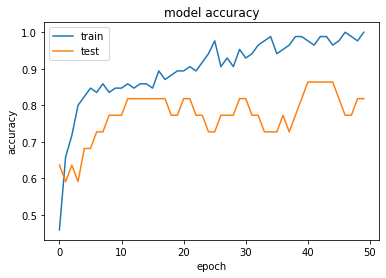

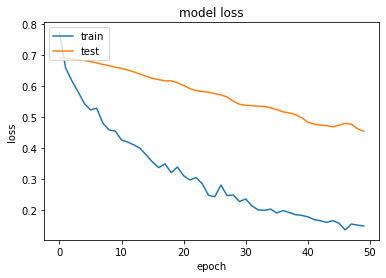

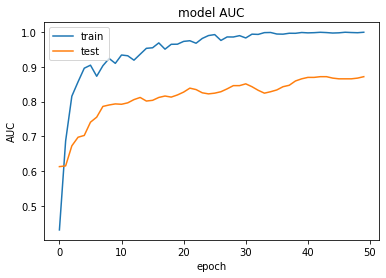

In [210]:
print(fittedModel.history.keys())
# summarize history for accuracy
plt.plot(fittedModel.history['accuracy'])
plt.plot(fittedModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for AUC
plt.plot(fittedModel.history['AUC'])
plt.plot(fittedModel.history['val_AUC'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [206]:
model = EEGNet(2, trial_shape[0], trial_shape[1], kernLength=256)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', lr=0.1, metrics=['accuracy', 'AUC'])
fittedModel    = model.fit(train_data, labels_train, validation_split=0.2, epochs=50)